# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i> <BR>
    
This course is based on specific versions of python packages. You can find the details of the same in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>. The manual also explains how to use these codes in other versions of python packages. <BR>

# Position Sizing


Gain expectancy = win% * avg_win% - loss% * abs(avg_loss%)

As the gain expectancy formula shows, there are two parts to any strategy. We just completed the signal part. We will now conclude with the money management module. Money is made in the money management module. 
Money management is the articulation between financial and emotional capital. 

We will explore various position sizing algorithms. 

1. Equal weight is a staple: All positions have the same percentage in the portfolio. For example, every position is 2% of the available capital. This one-size-fits-all method has two drawbacks. Firstly, it explicitly relies on the quality of the signal. If money management has no finesse, then gain expectancy will be blunt. Secondly, by excluding volatility from the position size, it invites volatility into the portfolio. 
​
2. Constant equity at risk: This method adds another variable stop loss. The risk remains constant, but the distance to the stop loss increases or reduces size. This method naturally penalizes volatile stocks. The higher the volatility, the farther away from the stop loss and the smaller the position size.



### Import libraries

In [1]:
# Data manipulation libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

# Calculates swing highs and lows
from scipy.signal import *
from scipy.signal import argrelextrema

# Appends new file paths to import modules
import sys
sys.path.append("..")

# All functions library
from data_modules.short_selling import relative
from data_modules.short_selling import swings
from data_modules.short_selling import regime_fc
from data_modules.short_selling import returns
from data_modules.short_selling import sma
from data_modules.short_selling import signal_fcstmt
from data_modules.short_selling import stop_loss
from data_modules.short_selling import transaction_costs

# Imports charting libraries
%matplotlib inline

# Construct a list of permutations
import itertools as it

### Import data

#### Files name:
1. WFC_Jan_2010_to_Jan_2019.csv, contains stock data for 'Wells Fargo'
2. BK_Jan_2010_to_Jan_2019.csv, contains stock data for 'Bank of New York Mellon'
3. JPM_Jan_2010_to_Jan_2019.csv, contains stock data for 'JP Morgan'
4. BAC_Jan_2010_to_Jan_2019.csv,   contains stock data for 'Bank of America'
5. USDGBP_Jan_2010_to_Jan_2019.csv, contains forex data for 'USDGBP'
6. SP500_Jan_2010_to_Jan_2019.csv, contains benchmark data for 'SP500'

This data is available in the last unit of this course. You can find this file in the downloadables section of the course.

In [2]:
# Data is stored in the directory 'data_modules' 
relative_path = "../data_modules/"

In [3]:
# Read and process data
stock = pd.read_csv(relative_path +'BAC_Jan_2010_to_Jan_2019.csv',index_col=0, parse_dates=True)

In [4]:
# Import and read benchmark data using the function 'read_csv'
benchmark =pd.read_csv(relative_path + 
    'SP500_Jan_2010_to_Jan_2019.csv', index_col=0, parse_dates=True)

benchmark_name = 'SP500'

# Import and read forex data using the function 'read_data'
forex = pd.read_csv(relative_path + 
    'USDGBP_Jan_2010_to_Jan_2019.csv',index_col=0, parse_dates=True)

forex_name = 'USDGBP'

#### 1. Create a stock universe:

Create a list of stock data, file_names[ ]
1. BAC_Jan_2010_to_Jan_2019, Bank of America
2. BK_Jan_2010_to_Jan_2019, Bank of New York Mellon
3. JPM_Jan_2010_to_Jan_2019, JP Morgan
4. WFC_Jan_2010_to_Jan_2019, Wells Fargo

In [5]:
# Create a list of stock data
file_names = ['BAC_Jan_2010_to_Jan_2019', 'BK_Jan_2010_to_Jan_2019',
              'JPM_Jan_2010_to_Jan_2019', 'WFC_Jan_2010_to_Jan_2019']

### Functions:

In this section, we will be creating functions.
So far, we have backtested for optimum raw performance. Performance alone is not a good measure of robustness. Next, we need to optimize metrics that matter. 
​
Those are metrics that give robust performance over time that will ultimately generate the type of performance that suits your objectives. Those are the following metrics:
1. Arithmetic gain expectancy: win rate * avg win-loss rate * abs(avg loss)
2. Geometric gain expectancy
3. Gain to pain ratio or profit factor: sum(profits)/sum (losses), a ratio version of the gain expectancy
4. Common sense ratio: GPR * tail ratio, this is a simple yet powerful metric. We want to have a positive gain expectancy and a right-skewed distribution of profits: short left, long right tails

In [6]:
# Basic statistics 

# Define a function 'hit_rate', calculates the hits
def hit_rate(returns, min_periods):
    hits = (returns[returns > 0].expanding(min_periods=min_periods).count() /
            returns.expanding(min_periods=min_periods).count()).fillna(method='ffill')
    return hits

# Define a function 'miss_rate', calculates the miss
def miss_rate(returns, min_periods):
    misses = (returns[returns < 0].expanding(min_periods=min_periods).count() /
              returns.expanding(min_periods=min_periods).count()).fillna(method='ffill')
    return misses

# Define a function 'avg_win', calculates the average win
def avg_win(returns, min_periods):
    average_win = (returns[returns > 0].expanding(min_periods=min_periods).sum() /
                   returns.expanding(min_periods=min_periods).count()).fillna(method='ffill')
    return average_win

# Define a function 'avg_loss', calculates the average loss
def avg_loss(returns, min_periods):
    average_loss = (returns[returns < 0].expanding(min_periods=min_periods).sum() /
                    returns.expanding(min_periods=min_periods).count()).fillna(method='ffill')
    return average_loss

In [7]:
# Define a function 'rolling_loss_rate', calculates the rolling loss rate
def rolling_loss_rate(returns, window):
    losing_days = returns.copy()
    losing_days[losing_days > 0] = np.nan
    losing_days_rolling = (losing_days.rolling(window).count()/window)
    return losing_days_rolling

# Define a function 'rolling_avg_loss', calculates the rolling average loss
def rolling_avg_loss(returns, window):
    avg_losing_day = returns.copy()
    avg_losing_day[avg_losing_day > 0] = 0
    _avg_losing_day = (avg_losing_day.rolling(window).sum()/window)
    return _avg_losing_day

# Define a function 'rolling_win_rate', calculates the rolling win rate
def rolling_win_rate(returns, window):
    good_days = returns.copy()
    good_days[good_days < 0] = np.nan
    good_days_rolling = (good_days.rolling(window).count()/window)
    return good_days_rolling

# Define a function 'rolling_avg_win', calculates the rolling average win 
def rolling_avg_win(returns, window):
    avg_good_day = returns.copy()
    avg_good_day[avg_good_day < 0] = 0
    _avg_good_day = (avg_good_day.rolling(window).sum()/window)
    return _avg_good_day

In [8]:
# Gain expectancies and Kelly criterion

# Define a function 'arige'
def arige(win_rate, avg_win, avg_loss):  # win% * avg_win% - loss% * abs(avg_loss%)
    return win_rate * avg_win + (1-win_rate) * avg_loss

# Define a function 'george'
def george(win_rate, avg_win, avg_loss):  # (1+ avg_win%)** win% * (1- abs(avg_loss%)) ** loss%  -1
    return (1+avg_win) ** win_rate * (1 + avg_loss) ** (1 - win_rate) - 1

# Define a function 'kelly'
def kelly(win_rate, avg_win, avg_loss):  # Kelly = win% / abs(avg_loss%) - loss% / avg_win%
    return win_rate / np.abs(avg_loss) - (1-win_rate) / avg_win

# Define a function 'count_signals'
def count_signals(signals):
    signal = signals.copy()
    signal[~((pd.isnull(signal.shift(1))) & (pd.notnull(signal)))] = np.nan
    return signal.expanding().count()

In [9]:
##### Performance statistics

# Define a function 'cumulative_returns'
def cumulative_returns(returns, min_periods):
    return returns.expanding(min_periods=min_periods).sum().apply(np.exp)

# Define a function 'cumulative_returns_pct'
def cumulative_returns_pct(returns, min_periods):
    return returns.expanding(min_periods=min_periods).sum().apply(np.exp) - 1

# Define a function 'average_returns'
def average_returns(returns, min_periods):
    avg_returns = (returns.expanding(min_periods=min_periods).sum() /
                   returns.expanding(min_periods=min_periods).count())
    return avg_returns

# Define a function 'stdev_returns'
def stdev_returns(returns, min_periods):
    std_returns = returns.expanding(min_periods=min_periods).std(ddof=0)
    return std_returns

# Define a function 'rolling_returns'
def rolling_returns(returns, window):
    return returns.rolling(window).sum().fillna(method='ffill')

# Define a function 'rolling_profits'
def rolling_profits(returns, window):
    profit_roll = returns.copy()
    profit_roll[profit_roll < 0] = 0
    profit_roll_sum = profit_roll.rolling(
        window, min_periods=1).sum().fillna(method='ffill')
    return profit_roll_sum

# Define a function 'rolling_losses'
def rolling_losses(returns, window):
    loss_roll = returns.copy()
    loss_roll[loss_roll > 0] = 0
    loss_roll_sum = loss_roll.rolling(
        window, min_periods=1).sum().fillna(method='ffill')
    return loss_roll_sum

# Define a function 'rolling_avg_returns'
def rolling_avg_returns(returns, window):
    roll_avg_returns = returns.rolling(
        window=window, min_periods=1).sum()/window
    roll_avg_returns = roll_avg_returns.fillna(method='ffill')
    return roll_avg_returns

# Define a function 'rolling_stdev_returns'
def rolling_stdev_returns(returns, window):
    return returns.rolling(window).std(ddof=0).fillna(method='ffill')

# Define a function 'rolling_sharpe'
def rolling_sharpe(returns, window):
    rolling_sharpe = rolling_avg_returns(
        returns, window) / rolling_stdev_returns(returns, window)
    return rolling_sharpe

# Define a function 'drawdown'
def drawdown(returns, min_periods):
    cum_rets = cumulative_returns(returns, min_periods)
    dd = cum_rets / cum_rets.cummax() - 1
    return dd

# Define a function 'max_drawdown'
def max_drawdown(returns, min_periods):
    max_dd = drawdown(returns, min_periods).cummin().fillna(method='ffill')
    return max_dd

In [10]:
# Robustness metrics


# Define a function 'ulcer_index'
def ulcer_index(returns, min_periods):
    cum_rets = cumulative_returns(returns).fillna(method='ffill')
    peak_rets = cum_rets.cummax()
    dd = np.log((cum_rets/peak_rets).fillna(1)) ** 2
    ulcer = np.sqrt(dd.expanding(min_periods=min_periods).sum())
    return ulcer


# Define a function 'grit_index'
def grit_index(returns, min_periods):
    cum_rets = cumulative_returns(returns, min_periods).fillna(method='ffill')
    peak_rets = cum_rets.cummax()
    dd = np.log((cum_rets/peak_rets)) ** 2
    ulcer = np.sqrt(dd.expanding(min_periods=min_periods).sum())
    grit = cum_rets * ulcer ** -1
    return grit


# Define a function 't_stat'
def t_stat(signal_count, expectancy):
    sqn = (signal_count ** 0.5) * expectancy / \
        expectancy.expanding().std(ddof=0)
    return sqn


# Define a function 'calmar_ratio'
def calmar_ratio(returns, min_periods):
    cum_rets = cumulative_returns(returns, min_periods).fillna(method='ffill')
    max_dd = np.abs(max_drawdown(returns, min_periods))
    calmar = cum_rets / max_dd
    return calmar


# Define a function 'rolling_profit_ratio'
def rolling_profit_ratio(returns, window):
    pr = (rolling_profits(returns, window).fillna(method='ffill') /
          abs(rolling_losses(returns, window).fillna(method='ffill')))
    return pr


# Define a function 'tail_ratio'
def tail_ratio(returns, window, percentile, limit):
    cumul_returns = returns.cumsum().fillna(method='ffill')
    left_tail = np.abs(cumul_returns.rolling(window).quantile(percentile))
    right_tail = cumul_returns.rolling(window).quantile(1-percentile)
    np.seterr(all='ignore')
    tail = np.maximum(np.minimum(right_tail / left_tail, limit), -limit)
    return tail


# Define a function 'common_sense_ratio'
def common_sense_ratio(pr, tr):
    return pr * tr

In [11]:
# Instantiate variables
min_periods = 50
window = 200
percentile = 0.05
limit = 5
tcs = 0.0025

In [12]:
# Instantiate the permutations of moving averages
st_list = range(10, 101, 10)
mt_list = range(50, 201, 20)

In [13]:
# Instantiate list dictionary and perf dataframe
list_dict = []

col_order = ['stmt', 'score', 'csr', 'grit', 'sqn',
             'perf']

In [14]:
# Fields to optimise (here, we optimise for robustness)
optimised_fields = ['score']
display_rows = 10
best_risk_adjusted_returns = 0

scoreboard = pd.DataFrame(columns=col_order)
high_score = pd.DataFrame()
perf = pd.DataFrame()

We loop through the four different stock datasets.

Steps within the for loop:
​
1. Create a relative series
2. Calculate the swings
3. Calculate the stock regime
4. Calculate returns for the relative and absolute closed price
5. Create another for loop
​

Steps within the second for loop:
1. Start with a condition: If short_term < mid_term,
2. Create dataframe
3. Calculate moving averages
4. Calculate positions based on the regime and moving average cross
5. Calculate excess returns for passive
6. Calculate daily & cumulative returns and include transaction costs
7. Calculate the gain expectancies, Performance and robustness.
8. Append the performance to a list

In [15]:
for n, file_name in enumerate(file_names):
    
    # Data is stored in the directory 'data_modules'
    relative_path = "../data_modules/"    
    
    new = pd.read_csv(relative_path + file_name +'.csv', index_col=0, parse_dates=True)
    # Create a relative series
    new = relative(stock_dataframe=new, benchmark_dataframe=benchmark, benchmark_name='SP500',
                   forex_dataframe=forex, forex_name='USDGBP', decimals=2, start=None, end=None)
    # Calculate the swings
    new = swings(df=new, high='rebased_high', low='rebased_low', argrel_window=20)
    # Calculate the stock regime
    new = regime_fc(df=new, close='rebased_close', swing_low='srebased_low',
                    swing_high='srebased_high', threshold=1.5, t_dev=63, decimals=3)

    # Calculate returns for the relative closed price
    # new['r_return_1d'] = returns(new['rebased_close'])
    # rets = pd.Series(new['rebased_close'])
    rets = new['rebased_close']
    new['r_return_1d'] = np.log(rets/rets.shift(1))
    

    # Calculate returns for the absolute closed price
    # new['return_1d'] = returns(new['Close'])
    rets = new['Close']
    new['return_1d'] = np.log(rets/rets.shift(1))

    for st, mt in it.product(st_list, mt_list):
            
        if st < mt:
            # Create dataframe
            data = pd.DataFrame()
            data[['rebased_close', 'Close', 'r_return_1d', 'return_1d', 'r_regime_floorceiling', 'srebased_low', 'srebased_high']] = \
                new[['rebased_close', 'Close', 'r_return_1d', 'return_1d',
                     'r_regime_floorceiling', 'srebased_low', 'srebased_high']].copy()

            # Calculate moving averages
            stmt = str(st)+str(mt)
            r_st_ma = sma(df=data, price='rebased_close',
                          ma_per=st, min_per=1, decimals=2)
            r_mt_ma = sma(df=data, price='rebased_close',
                          ma_per=mt, min_per=1, decimals=2)

            # Calculate positions based on regime and ma cross
            data['s'+stmt] = signal_fcstmt(
                regime=data['r_regime_floorceiling'], st=r_st_ma, mt=r_mt_ma)
            data['sl'+stmt] = stop_loss(signal=data['s'+stmt],
                                        close=data['rebased_close'],
                                        s_low=data['srebased_low'],
                                        s_high=data['srebased_high'])

            # Date of initial position to calculate excess returns for passive
            # Passive stats are recalculated each time because start date changes with stmt sma
            first_position_dt = data[pd.notnull(data['s'+stmt])].index[0]
            data_sliced = data[first_position_dt:].copy()

            # Calculate daily & cumulative returns and include transaction costs
            data_sliced['d'+stmt] = data_sliced['r_return_1d'] * \
                data_sliced['s'+stmt].shift(1)
            data_sliced['d'+stmt] = transaction_costs(df=data_sliced,
                                                      position_column='s'+stmt, daily_return='d'+stmt, tcs=tcs)

            # Cumulative performance must be higher than passive or regime (w/o transaction costs)
            passive_1d = data_sliced['r_return_1d']
            returns = data_sliced['d'+stmt]

            # Performance 
            trade_count = count_signals(signals=data_sliced['s'+stmt])
            cumul_passive = cumulative_returns(passive_1d, min_periods)
            cumul_returns = cumulative_returns(returns, min_periods)
            cumul_excess = cumul_returns - cumul_passive - 1
            cumul_returns_pct = cumulative_returns_pct(returns, min_periods)
            roll_profits = rolling_profits(
                returns, window).fillna(method='ffill')

            # Gain Expectancies 
            _hit_rate = hit_rate(returns, min_periods)
            _avg_win = avg_win(returns, min_periods)
            _avg_loss = avg_loss(returns, min_periods)
            geo_ge = george(win_rate=_hit_rate, avg_win=_avg_win,
                            avg_loss=_avg_loss).apply(np.exp)-1

            # Robustness metrics
            grit = grit_index(returns, min_periods)
            calmar = calmar_ratio(returns, min_periods)
            pr = roll_profits
            tr = tail_ratio(returns, window, percentile, limit)
            csr = common_sense_ratio(pr, tr)
            sqn = t_stat(signal_count=trade_count, expectancy=geo_ge)

            tickerstmt = file_name + str(stmt)

            # Add cumulative performance to the perf dataframe
            perf[tickerstmt] = cumul_returns

            # Append list
            row = {'ticker': file_name, 'tstmt': tickerstmt, 'stmt': stmt,
                   'perf': round(cumul_returns_pct[-1], 3),
                   'excess': round(cumul_excess[-1], 3),
                   'score': round(grit[-1] * csr[-1] * sqn[-1], 1),
                   'trades': trade_count[-1],
                   'win': round(_hit_rate[-1], 3),
                   'avg_win': round(_avg_win[-1], 3),
                   'avg_loss': round(_avg_loss[-1], 3),
                   'geo_GE': round(geo_ge[-1], 4),
                   'grit': round(grit[-1], 1),
                   'csr': round(csr[-1], 1),
                   'p2l': round(pr[-1], 1),
                   'tail': round(tr[-1], 1),
                   'sqn': round(sqn[-1], 1)
                   }
            list_dict.append(row)

            # Save high_score for later use in the position sizing module
            if (csr[-1] * sqn[-1] * grit[-1]) > best_risk_adjusted_returns:
                best_risk_adjusted_returns = csr[-1] * sqn[-1] * grit[-1]
                high_score = data.copy()
                high_score['score'] = csr[-1] * sqn[-1] * grit[-1]
                high_score['trades'] = trade_count
                high_score['r_perf'] = cumul_returns
                high_score['csr'] = csr
                high_score['geo_GE'] = geo_ge
                high_score['sqn'] = sqn

            else:
                pass

        else:
            pass


In [16]:
data.s100190.dropna()

Date
2010-10-04   -1.0
2010-10-05   -1.0
2010-10-06   -1.0
2010-10-07   -1.0
2010-10-08   -1.0
             ... 
2018-04-10    1.0
2018-04-11    1.0
2018-04-12    1.0
2018-04-13    1.0
2018-04-16    1.0
Name: s100190, Length: 1341, dtype: float64

In [17]:
# Populate scoreboard dataframe and sort by ['grit','csr','excess']
scoreboard = pd.DataFrame.from_dict(list_dict)
scoreboard = scoreboard[col_order]
scorebaord = scoreboard.groupby(['stmt'])

scoreboard = scoreboard.sort_values(by=optimised_fields, ascending=False)

# Print top 10 rows
print('Top ' + str(display_rows))
print(scoreboard[:display_rows])

# Print top 10 rows
print('Bottom '+str(display_rows))
print(scoreboard[-int(display_rows):])

Top 10
       stmt  score  csr  grit   sqn   perf
16     3050   10.6  0.6   1.9   8.7  7.802
8      2050    7.3  0.6   1.6   7.5  5.458
1      1070    5.5  0.7   1.5   5.3  5.815
0      1050    4.6  0.6   1.3   5.9  4.313
196   90150    4.5  0.5   0.9   9.5  1.223
24     4050    4.4  0.7   1.0   6.1  5.883
202  100170    3.8  0.6   0.8   8.2  0.781
152    3050    3.8  0.3   0.8  14.8  1.130
39     6070    3.3  0.7   0.8   5.8  4.500
63   100110    3.0  0.8   0.6   6.6  2.741
Bottom 10
       stmt  score  csr  grit  sqn   perf
208   10130    0.0  0.0   0.1  1.9  0.060
271  100190    0.0 -0.1   0.1 -1.6 -0.283
141   10150   -0.1  0.9   0.2 -0.3  0.381
148   20130   -0.1  0.9   0.2 -1.0  0.134
75    10190   -0.1  0.9   0.2 -0.4  0.192
80    20130   -0.1  1.9   0.1 -0.3  0.062
81    20150   -0.1  1.9   0.1 -0.5  0.045
156   30130   -0.2  1.7   0.2 -0.6  0.149
74    10170   -0.3  1.6   0.1 -1.3  0.077
73    10150   -0.3  2.0   0.1 -1.0  0.057


In [18]:
# Define a function 'round_lot'
def round_lot(weight, capital, fx_rate, price_local, roundlot):
    book_value = weight * capital
    shares = book_value * fx_rate / price_local
    lot = round(shares/roundlot, 0) * roundlot
    return lot

# Define a function 'equity_at_risk'
def equity_at_risk(px_adj, sLoss, risk):
    dsl = px_adj / sLoss - 1  # distance to stop loss in currency adjusted relative
    eqty_at_risk = risk / dsl  # weight in currency adjusted relative terms
    return eqty_at_risk

Index(['rebased_close', 'Close', 'r_return_1d', 'return_1d',
       'r_regime_floorceiling', 'srebased_low', 'srebased_high', 's3050',
       'sl3050', 'score', 'trades', 'r_perf', 'csr', 'geo_GE', 'sqn'],
      dtype='object')

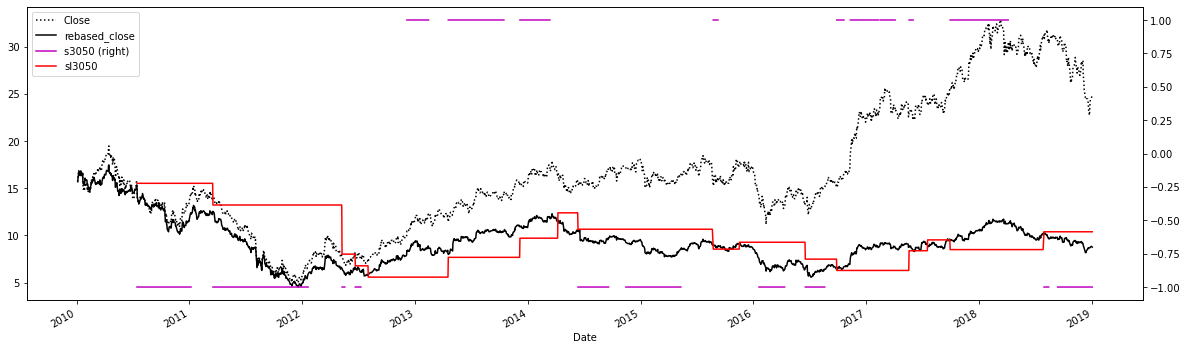

In [19]:
# Make a copy of high_score
data = high_score.copy()
data_cols = list(data.columns)
data[
    ['Close', 'rebased_close', data_cols[7], data_cols[8]]
].plot(
    secondary_y=[data_cols[7]],
    style=['k:', 'k', 'm', 'r'], 
    figsize=(20, 6))

# Print the columns
data.columns

In [20]:
# Make a copy of high_score
data = high_score.copy()
data_cols = list(data.columns)

In [21]:
# Declare variables

K = 1000000
constant_risk = 0.25 / 100
constant_weight = 3 / 100
signal = data[data_cols[7]]
signal[pd.isnull(signal)] = 0
position = data[data_cols[7]].shift(1)
position[pd.isnull(position)] = 0
sLoss = data[data_cols[8]]
data_cols[8]

# Calculate the daily Close chg_1d
close_1d = data['Close'].diff().fillna(0)

# Define posSizer weight
data['eqty_risk'] = equity_at_risk(
    px_adj=data['rebased_close'], sLoss=sLoss, risk=constant_risk)

data['eqty_risk']

Date
2010-01-04         NaN
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
                ...   
2018-12-26   -0.015446
2018-12-27   -0.015823
2018-12-28   -0.016321
2018-12-31   -0.016742
2019-01-02   -0.015920
Name: eqty_risk, Length: 2264, dtype: float64

<AxesSubplot:xlabel='Date'>

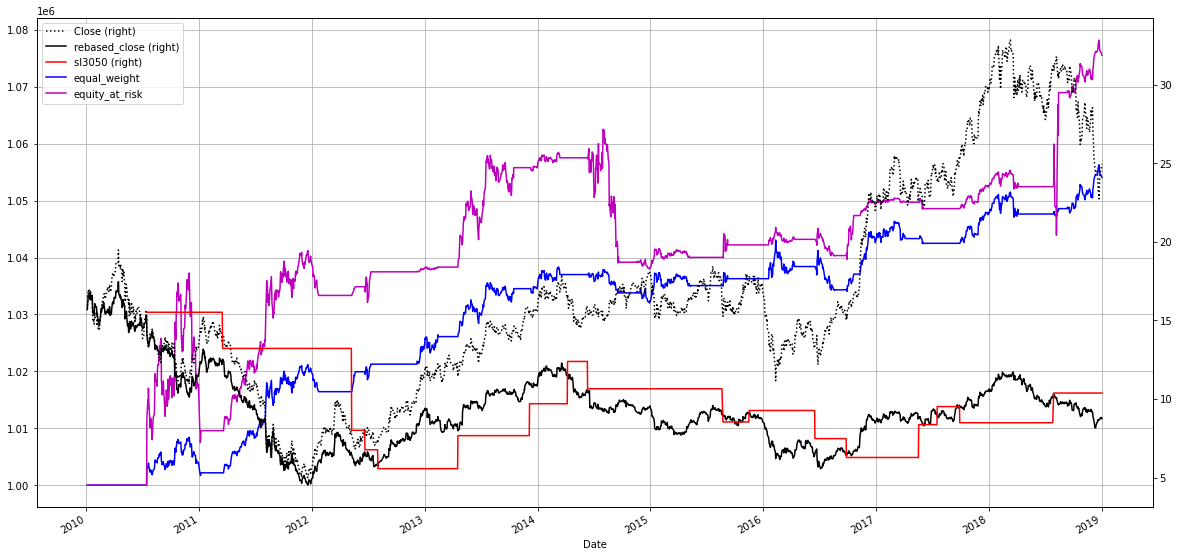

In [22]:


# Instantiation of equity curves
data['equity_at_risk'] = K
data['equal_weight'] = K

# Instantiation of round_lot for posSizer
eqty_risk_lot = 0
equal_weight_lot = 0

for i in range(len(data)):

    data['equity_at_risk'].iat[i] = (
        data['equity_at_risk'].iat[i-1] + close_1d.iat[i] * eqty_risk_lot * abs(position.iat[i])
    )

    data['equal_weight'].iat[i] = (
        data['equal_weight'].iat[i-1] + close_1d.iat[i] * equal_weight_lot * position.iat[i]
    )

    if (signal.iat[i-1] == 0) & (signal.iat[i] != 0):
        eqty_risk_lot = round_lot(
            weight=data['eqty_risk'].iat[i],
            capital=data['equity_at_risk'].iat[i], 
            fx_rate=1,
            price_local=data['Close'].iat[i], 
            roundlot=100
        )

        equal_weight_lot = round_lot(
            weight=constant_weight,
            capital=data['equal_weight'].iat[i], 
            fx_rate=1,
            price_local=data['Close'].iat[i], 
            roundlot=100
        )

    else:
        pass

# print(equal_weight_lot,kelly_lot)

couleurs = ['k:', 'k', 'r', 'b', 'm', 'm-.', 'm:', 'g', 'c']
data[
    ['Close', 'rebased_close', data_cols[8], 'equal_weight', 'equity_at_risk']
].plot(
    secondary_y=['Close', 'rebased_close', data_cols[8]]
    , style=couleurs, 
    figsize=(20, 10), 
    grid=True
)

In [23]:
data

,rebased_close,Close,r_return_1d,return_1d,r_regime_floorceiling,srebased_low,srebased_high,s3050,sl3050,score,trades,r_perf,csr,geo_GE,sqn,eqty_risk,equity_at_risk,equal_weight
Date,,,,,,,,,,,,,,,,,,
2010-01-04,15.69,15.69,NaN,NaN,0.0,NaN,NaN,0.0,NaN,10.556976,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000
2010-01-05,16.04,16.20,0.022062,0.031988,0.0,NaN,NaN,0.0,NaN,10.556976,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000
2010-01-06,16.24,16.39,0.012392,0.011660,0.0,NaN,NaN,0.0,NaN,10.556976,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000
2010-01-07,16.61,16.93,0.022528,0.032416,0.0,NaN,NaN,0.0,NaN,10.556976,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000
2010-01-08,16.51,16.78,-0.006039,-0.008899,0.0,NaN,NaN,0.0,NaN,10.556976,NaN,NaN,NaN,NaN,NaN,NaN,1000000,1000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-26,8.70,24.11,0.003454,0.058941,-1.0,NaN,NaN,-1.0,10.38,10.556976,19.0,8.852084,0.642512,0.001075,9.009663,-0.015446,1076570,1054919
2018-12-27,8.74,24.37,0.004587,0.010726,-1.0,NaN,NaN,-1.0,10.38,10.556976,19.0,8.811571,0.642512,0.001075,9.011910,-0.015823,1076258,1054659
2018-12-28,8.79,24.39,0.005705,0.000820,-1.0,NaN,NaN,-1.0,10.38,10.556976,19.0,8.761449,0.642512,0.001075,9.010467,-0.016321,1076234,1054639


<AxesSubplot:xlabel='Date'>

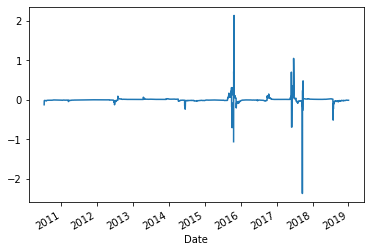

In [25]:
data.eqty_risk.plot()

### Conclusion
This notebook gives you a basic framework to create a powerful position sizing algorithm. Position sizing is very important and if applied correctly, it can dramatically improve your strategy performance and help you avoid unnecessary losses. From this exercise, we can conclude out of the two, equity at risk method works the best. Equity at risk is a time tested method. And, it is suggested that people should try it on different data sets to learn more.
</span> <BR><BR>